In [244]:
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dotenv import load_dotenv
import datetime as dt
import requests
#import json
import base64
import time
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn import tree
import fire
import pickle
import cbpro
from Historic_Crypto import HistoricalData

In [245]:
""" importing the cbpro library and assigning the public client """

public_client = cbpro.PublicClient()

In [246]:
""" loading the private client's api keys and secret keys """
load_dotenv()
api_key = os.getenv("COINBASE_SAND_API")
api_secret = os.getenv("COINBASE_SAND_SECRET")
api_passphrase = os.getenv("COINBASE_SAND_PASSPHRASE")



In [247]:
""" authorizing the api to interact with the sandbox"""

auth_client = cbpro.AuthenticatedClient(api_key, api_secret, api_passphrase,
                                  api_url="https://api-public.sandbox.pro.coinbase.com")

next is setting the buy and sell signals

In [248]:
""" importing historic crypto to fecth the historical data for the trading strategies and model """


btc_hist_data = HistoricalData('BTC-USD',86400,'2017-01-01-00-00').retrieve_data()

Checking input parameters are in the correct format...
Formatting Dates...
Checking if ticker supplied is available on the CoinBase Pro API...
Connected to the CoinBase Pro API...
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction...
Data for chunk 0 of 5 extracted
Data for chunk 1 of 5 extracted
Data for chunk 2 of 5 extracted
Data for chunk 3 of 5 extracted
Data for chunk 4 of 5 extracted
Data for chunk 5 of 5 extracted


In [249]:
""" printing out the historical data and writing to .csv file """
btc_hist_data.to_csv('btc_hist_data.csv')
btc_hist_data

,low,high,open,close,volume
time,,,,,
2017-01-02,990.52,1034.39,992.96,1011.45,7723.635752
2017-01-03,1006.71,1036.99,1011.52,1020.67,8615.260058
2017-01-04,1018.00,1147.00,1020.69,1130.30,16222.230267
2017-01-05,880.00,1175.00,1131.10,1007.00,20446.405615
2017-01-06,875.01,1033.85,1007.00,895.71,14274.259206
...,...,...,...,...,...
2021-10-14,56832.32,58520.71,57367.32,57359.51,12198.024579
2021-10-15,56867.11,62910.00,57359.51,61695.39,27105.197645
2021-10-16,60139.01,62350.00,61690.32,60877.42,10161.258198


In [250]:
""" creating a signals dataframe to hold the values of the actual returns """

signals_df = btc_hist_data.loc[:, ["close"]]

signals_df["Actual Returns"] = btc_hist_data["close"].pct_change()

signals_df = signals_df.dropna()

display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
time,,
2017-01-03,1020.67,0.009116
2017-01-04,1130.30,0.107410
2017-01-05,1007.00,-0.109086
2017-01-06,895.71,-0.110516
2017-01-07,909.00,0.014837


,close,Actual Returns
time,,
2021-10-14,57359.51,-0.000136
2021-10-15,61695.39,0.075591
2021-10-16,60877.42,-0.013258
2021-10-17,61527.11,0.010672
2021-10-18,62279.74,0.012232


utc translation or conversion there should be a library utc conversioin

In [251]:
""" setting the rolling windows for the long and short positions"""

short_window = 25
long_window = 100

signals_df['SMA_Fast'] = btc_hist_data['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = btc_hist_data['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
time,,,,
2017-04-11,1223.99,0.011562,1087.7464,1052.3277
2017-04-12,1214.17,-0.008023,1097.5132,1054.3549
2017-04-13,1177.05,-0.030572,1103.8156,1055.9187
2017-04-14,1173.74,-0.002812,1108.9668,1056.3531
2017-04-15,1178.85,0.004354,1111.5440,1058.0716


,close,Actual Returns,SMA_Fast,SMA_Slow
time,,,,
2021-10-14,57359.51,-0.000136,48610.0964,44030.8164
2021-10-15,61695.39,0.075591,49357.3932,44308.9847
2021-10-16,60877.42,-0.013258,50163.7060,44588.9994
2021-10-17,61527.11,0.010672,50881.7864,44866.0279
2021-10-18,62279.74,0.012232,51577.0724,45153.6718


In [252]:
""" creating a new dataframe to hold the signals data"""
signals_df["Signal"] = 0.0

signals_df['Signal'][short_window:] = np.where(
    signals_df['SMA_Fast'][short_window:] > signals_df['SMA_Slow'][short_window:], 1.0, 0.0
)

signals_df = signals_df.dropna()
display(signals_df.head())
display(signals_df.tail())


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
time,,,,,
2017-04-11,1223.99,0.011562,1087.7464,1052.3277,0.0
2017-04-12,1214.17,-0.008023,1097.5132,1054.3549,0.0
2017-04-13,1177.05,-0.030572,1103.8156,1055.9187,0.0
2017-04-14,1173.74,-0.002812,1108.9668,1056.3531,0.0
2017-04-15,1178.85,0.004354,1111.5440,1058.0716,0.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
time,,,,,
2021-10-14,57359.51,-0.000136,48610.0964,44030.8164,1.0
2021-10-15,61695.39,0.075591,49357.3932,44308.9847,1.0
2021-10-16,60877.42,-0.013258,50163.7060,44588.9994,1.0
2021-10-17,61527.11,0.010672,50881.7864,44866.0279,1.0
2021-10-18,62279.74,0.012232,51577.0724,45153.6718,1.0


In [253]:
""" creating entry exit columns for the plot"""
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

In [254]:
""" creating a plot to visualize the trades"""

exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)


entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)


security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)


moving_avgs = signals_df[['SMA_Slow', 'SMA_Fast']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)


entry_exit_plot = security_close * moving_avgs * entry * exit


entry_exit_plot.opts(
    title="Bitcoin - SMASlow, SMAFast, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [time]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [time]   (value)
   .Scatter.Close.I  :Scatter   [time]   (close)
   .Scatter.Close.II :Scatter   [time]   (close)

In [255]:
""" writing the signals df to .csv"""
signals_df.to_csv("signals.csv")

In [256]:
""" evaluating the balance of the signals"""
signals_df['Signal'].value_counts()

1.0    984
0.0    668
Name: Signal, dtype: int64

In [257]:
""" creating a strategy returns colums to hold the returns data using the signals
programmed in the code
"""
signals_df['Actual Returns'] = signals_df['close'].pct_change()
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
time,,,,,,,
2017-04-11,1223.99,NaN,1087.7464,1052.3277,0.0,NaN,NaN
2017-04-12,1214.17,-0.008023,1097.5132,1054.3549,0.0,0.0,-0.0
2017-04-13,1177.05,-0.030572,1103.8156,1055.9187,0.0,0.0,-0.0
2017-04-14,1173.74,-0.002812,1108.9668,1056.3531,0.0,0.0,-0.0
2017-04-15,1178.85,0.004354,1111.5440,1058.0716,0.0,0.0,0.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
time,,,,,,,
2021-10-14,57359.51,-0.000136,48610.0964,44030.8164,1.0,0.0,-0.000136
2021-10-15,61695.39,0.075591,49357.3932,44308.9847,1.0,0.0,0.075591
2021-10-16,60877.42,-0.013258,50163.7060,44588.9994,1.0,0.0,-0.013258
2021-10-17,61527.11,0.010672,50881.7864,44866.0279,1.0,0.0,0.010672
2021-10-18,62279.74,0.012232,51577.0724,45153.6718,1.0,0.0,0.012232


In [258]:
""" plotting the candlestick data with the entry and exit points """
                             
fig = go.Figure(data=[go.Candlestick(x = btc_hist_data.index,
                                    open = btc_hist_data['open'],
                                    high = btc_hist_data['high'],
                                    low = btc_hist_data['low'],
                                    close = btc_hist_data['close'],
                                    ),
                     go.Scatter(x=signals_df.index, y=signals_df['SMA_Fast'], line=dict(color='purple', width=1)),
                     go.Scatter(x=signals_df.index, y=signals_df['SMA_Slow'], line=dict(color='green', width=1))])
                     


fig.show()


<AxesSubplot:title={'center':'Bitcoin Cumulative Returns'}, xlabel='time'>

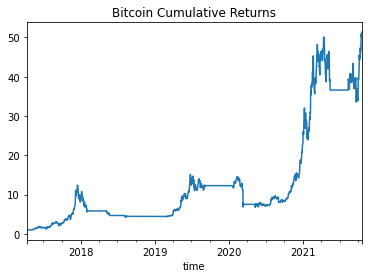

In [259]:
""" plotting the strategy returns to better see the data """

(1 + signals_df['Strategy Returns']).cumprod().plot(x="date", title="Bitcoin Cumulative Returns")

Here we start the backtesting

In [260]:
""" simple backtesting using cumulative returns and $100,000"""

initial_capital = float(100000)
btc_quantity = 1

signals_df['Position'] = btc_quantity * signals_df['Signal']
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()
signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Position']
signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum()
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,,,
2017-04-11,1223.99,NaN,1087.7464,1052.3277,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2017-04-12,1214.17,-0.008023,1097.5132,1054.3549,0.0,0.0,-0.0,0.0,0.0,0.0,100000.0,100000.0,NaN,NaN
2017-04-13,1177.05,-0.030572,1103.8156,1055.9187,0.0,0.0,-0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2017-04-14,1173.74,-0.002812,1108.9668,1056.3531,0.0,0.0,-0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2017-04-15,1178.85,0.004354,1111.5440,1058.0716,0.0,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,,,
2021-10-14,57359.51,-0.000136,48610.0964,44030.8164,1.0,0.0,-0.000136,1.0,0.0,57359.51,101277.99,158637.50,-0.000049,0.586375
2021-10-15,61695.39,0.075591,49357.3932,44308.9847,1.0,0.0,0.075591,1.0,0.0,61695.39,101277.99,162973.38,0.027332,0.629734
2021-10-16,60877.42,-0.013258,50163.7060,44588.9994,1.0,0.0,-0.013258,1.0,0.0,60877.42,101277.99,162155.41,-0.005019,0.621554
2021-10-17,61527.11,0.010672,50881.7864,44866.0279,1.0,0.0,0.010672,1.0,0.0,61527.11,101277.99,162805.10,0.004007,0.628051
2021-10-18,62279.74,0.012232,51577.0724,45153.6718,1.0,0.0,0.012232,1.0,0.0,62279.74,101277.99,163557.73,0.004623,0.635577


HERE WE START THE MACHINE LEARNING MODEL

In [261]:
""" creating an X features dataframe to split the data into training and testing data"""

X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().copy().dropna()
X.head()

,SMA_Fast,SMA_Slow
time,,
2017-04-12,1087.7464,1052.3277
2017-04-13,1097.5132,1054.3549
2017-04-14,1103.8156,1055.9187
2017-04-15,1108.9668,1056.3531
2017-04-16,1111.5440,1058.0716


In [262]:
""" creating a signals df to hold the X and y data for the ML model"""

signals_df['Signal'] = 0.0

"""creating the buy signal"""
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

"""creating the sell signal"""
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

In [263]:
""" copying the signal data to the y variable"""
y = signals_df['Signal'].copy().dropna()

In [264]:
""" checking the value counts """

y.value_counts()

 1.0    884
-1.0    767
 0.0      1
Name: Signal, dtype: int64

In [265]:
X

,SMA_Fast,SMA_Slow
time,,
2017-04-12,1087.7464,1052.3277
2017-04-13,1097.5132,1054.3549
2017-04-14,1103.8156,1055.9187
2017-04-15,1108.9668,1056.3531
2017-04-16,1111.5440,1058.0716
...,...,...
2021-10-14,48205.9528,43799.4786
2021-10-15,48610.0964,44030.8164
2021-10-16,49357.3932,44308.9847


In [266]:
""" telling the algorithm when to start the training data """
training_begin = X.index.min()
print(training_begin)

2017-04-12 00:00:00


In [267]:
""" telling the algorithm when to end the training data """
training_end = X.index.min() + DateOffset(years=1)

print(training_end)

2018-04-12 00:00:00


In [268]:
""" creating new training dataframes using the start/end data"""
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [269]:
""" creating new testing dataframes using the start/end data"""
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [270]:
""" checking the numbers """
X_test.shape

(1286, 2)

In [283]:
""" scaling the X data using StandardScaler instance """

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

""" resampling the data for better predictions X is overbalanced"""

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)


In [291]:
""" best so far using the DecisionTree Classifier to train and predict trading signals """


model = tree.DecisionTreeClassifier(random_state=3, max_depth=None, splitter='best')
 
model = model.fit(X_resampled, y_resampled)
 
pred = model.predict(X_resampled)

pred


array([-1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,
        1., -1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,
       -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
        1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,
       -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1

In [284]:
""" creating an SVM model to backtest the data keeping this in case I need it"""
"""
model = svm.SVC()
 
model = model.fit(X_resampled, y_resampled)
 
pred = model.predict(X_resampled)

pred
"""

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [292]:
""" creating a classification report to see the model's training performance """
testing_report = classification_report(y_resampled, pred)

print(testing_report)

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       202
         1.0       1.00      1.00      1.00       202

    accuracy                           1.00       404
   macro avg       1.00      1.00      1.00       404
weighted avg       1.00      1.00      1.00       404



Backesting the SVM Resampled Model

In [293]:
""" creating a testing report to see how my model performed with test data"""

testing_signal_predictions = model.predict(X_test_scaled)
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.06      0.10       603
         1.0       0.53      0.93      0.67       683

    accuracy                           0.52      1286
   macro avg       0.48      0.49      0.39      1286
weighted avg       0.48      0.52      0.41      1286



In [294]:
""" creating a new dataframe to hold the predictions of y using the X_test data 
We are using the actual and predicted returns to calculate the strategy returns
"""

predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["Predicted Signal"] = testing_signal_predictions

predictions_df["Actual Returns"] = signals_df["Actual Returns"]

predictions_df["Trading Algorithm Returns"] = (
    predictions_df["Actual Returns"] * predictions_df["Predicted Signal"]
)


display(predictions_df.head())
display(predictions_df.tail())

,Predicted Signal,Actual Returns,Trading Algorithm Returns
time,,,
2018-04-12,1.0,0.140143,0.140143
2018-04-13,1.0,-0.002882,-0.002882
2018-04-14,1.0,0.013926,0.013926
2018-04-15,1.0,0.044000,0.044000
2018-04-16,1.0,-0.036662,-0.036662


,Predicted Signal,Actual Returns,Trading Algorithm Returns
time,,,
2021-10-14,1.0,-0.000136,-0.000136
2021-10-15,1.0,0.075591,0.075591
2021-10-16,1.0,-0.013258,-0.013258
2021-10-17,1.0,0.010672,0.010672
2021-10-18,1.0,0.012232,0.012232


In [295]:
predictions_df["Trading Algorithm Returns"].value_counts()

-0.018106    1
 0.000293    1
 0.068997    1
 0.009561    1
-0.010197    1
            ..
 0.017561    1
-0.037700    1
 0.009719    1
 0.080705    1
 0.027345    1
Name: Trading Algorithm Returns, Length: 1286, dtype: int64

predictions_df.sample(10)

<AxesSubplot:xlabel='time'>

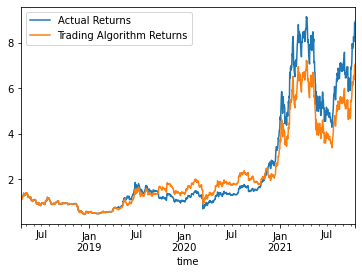

In [296]:
""" plotting the actual returns vs the strategy returns to analyse the performance of the model"""


(1 + predictions_df[["Actual Returns", "Trading Algorithm Returns"]]).cumprod().plot()

In [279]:
""" saving model for later use """
import pickle
filename = 'bitcoin_tree.sav'
pickle.dump(model, open(filename, 'wb'))

CREATING AN EXECUTION FUNCTION FOR TRADES

In [280]:
""" buy order btc from usd """
def buy():
    auth_client.buy(size='1', #BTC
        order_type='market',
        product_id='BTC-USD')

""" sell order btc to usd """

def sell():
    auth_client.sell(size='1', #BTC
        order_type='market',
        product_id='BTC-USD')


In [281]:
signal = predictions_df["Predicted Signal"]
signal

time
2018-04-12    1.0
2018-04-13    1.0
2018-04-14    1.0
2018-04-15    1.0
2018-04-16    1.0
             ... 
2021-10-14    1.0
2021-10-15    1.0
2021-10-16    1.0
2021-10-17    1.0
2021-10-18    1.0
Name: Predicted Signal, Length: 1286, dtype: float64

In [282]:
""" have to create a for loop look through each colums .apply(write if statement)
I am still working on this.  This function will execute the live trade on sandbox"""
import fire
signal = predictions_df["Predicted Signal"]
for index, row in predictions_df.iterrows():
  if signal == 1.0:
    buy()
  elif signal == -1.0:
    sell()
  elif signal == 0.0:
    print(f"hold")

if __name__ == "__main__":
    fire.Fire(run)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().